A2D2_Anomaly_Detection_Tutorial_Based.ipynb

This notebook adapts the A2D2 tutorial's data handling for camera images
to demonstrate anomaly detection using a Variational Autoencoder (VAE).
It assumes a small subset (preview) of the A2D2 dataset is available locally in the specified directory structure.

Based on Project 4: Generative AI Applications in Autonomous Vehicle CyberPhysical Systems, focusing on enhancing sensor data and improving security.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip install opencv-python open3d numpy matplotlib tensorflow

<h3>Section 1: Setup and Data Loading </h3>

<h4>Importing Libraries</h4>

In [ ]:
import json
import pprint
import numpy as np
import numpy.linalg as la
import cv2
import glob
from os.path import join
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import random

Setting Threads for faster computing

In [ ]:
import os

# Physical Cores
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
# Logical cores
os.environ["TF_NUM_INTEROP_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"

<h4>Defining Funtions</h4>

In [ ]:

# Define a small constant for view calculations (from tutorial)
EPSILON = 1.0e-10

# Functions adapted from A2D2 Tutorial for Configuration and Views
# (These are needed to potentially understand sensor placement, though not directly used in this image-only anomaly detection example)
def get_axes_of_a_view(view):
    x_axis = view['x-axis']
    y_axis = view['y-axis']
    x_axis_norm = la.norm(x_axis)
    y_axis_norm = la.norm(y_axis)
    if (x_axis_norm < EPSILON or y_axis_norm < EPSILON):
        raise ValueError("Norm of input vector(s) too small.")
    x_axis = x_axis / x_axis_norm
    y_axis = y_axis / y_axis_norm
    y_axis = y_axis - x_axis * np.dot(y_axis, x_axis)
    z_axis = np.cross(x_axis, y_axis)
    y_axis_norm = la.norm(y_axis)
    z_axis_norm = la.norm(z_axis)
    if (y_axis_norm < EPSILON) or (z_axis_norm < EPSILON):
        raise ValueError("Norm of view axis vector(s) too small.")
    y_axis = y_axis / y_axis_norm
    z_axis = z_axis / z_axis_norm
    return x_axis, y_axis, z_axis

def get_origin_of_a_view(view):
    return view['origin']

def get_transform_to_global(view):
    x_axis, y_axis, z_axis = get_axes_of_a_view(view)
    origin = get_origin_of_a_view(view)
    transform_to_global = np.eye(4)
    transform_to_global[0:3, 0] = x_axis
    transform_to_global[0:3, 1] = y_axis
    transform_to_global[0:3, 2] = z_axis
    transform_to_global[0:3, 3] = origin
    return transform_to_global

def get_transform_from_global(view):
    transform_to_global = get_transform_to_global(view)
    trans = np.eye(4)
    rot = np.transpose(transform_to_global[0:3, 0:3])
    trans[0:3, 0:3] = rot
    trans[0:3, 3] = np.dot(rot, -transform_to_global[0:3, 3])
    return trans

def undistort_image(image, cam_name, config):
    if cam_name in ['front_left', 'front_center',
                    'front_right', 'side_left',
                    'side_right', 'rear_center']:
        intr_mat_undist = np.asarray(config['cameras'][cam_name]['CamMatrix'])
        intr_mat_dist = np.asarray(config['cameras'][cam_name]['CamMatrixOriginal'])
        dist_parms = np.asarray(config['cameras'][cam_name]['Distortion'])
        lens = config['cameras'][cam_name]['Lens']

        if (lens == 'Fisheye'):
            return cv2.fisheye.undistortImage(image, intr_mat_dist, D=dist_parms, Knew=intr_mat_undist)
        elif (lens == 'Telecam'):
            return cv2.undistort(image, intr_mat_dist, distCoeffs=dist_parms, newCameraMatrix=intr_mat_undist)
        else:
            return image
    else:
        return image

<h4>Loading Data</h4>

In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/CPS-Final/'

config_path = join(root_path, 'cams_lidars.json')

with open (config_path, 'r') as f:
    config = json.load(f)

# Load Training Data
x_train_normal = np.array([])
if config:
    camera_name = 'cam_front_center'
    train_image_pattern = join(root_path, 'camera_lidar/', '*/', 'camera/', camera_name, '*.png')
    all_train_image_files = sorted(glob.glob(train_image_pattern))

    if not all_train_image_files:
        print(f"Error: No training image files found matching pattern: {train_image_pattern}")
    else:
        max_desired_train_images = 1000
        num_train_images_to_load = min(max_desired_train_images, len(all_train_image_files))

        # Select a random sample for training
        selected_train_image_files = random.sample(all_train_image_files, num_train_images_to_load)
        train_image_list = []
        print(f"\nLoading {num_train_images_to_load} training images from {camera_name} (camera_lidar)...")

        for img_file in selected_train_image_files:
             img = cv2.imread(img_file)
             if img is not None:
                 img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                 undist_img = undistort_image(img_rgb, camera_name, config)
                 target_size = (256, 160)
                 resized_img = cv2.resize(undist_img, target_size)
                 train_image_list.append(resized_img)
             else:
                 print(f"Warning: Could not load training image file {img_file}")

        if train_image_list:
           # Normalize to [0, 1]
           x_train_normal = np.array(train_image_list).astype("float32") / 255.0
        print(f"Loaded and preprocessed training image data shape: {x_train_normal.shape}")

# Load Validation Data from camera_lidar_semantic_bboxes
x_val_normal = np.array([])
if config:
    camera_name = 'cam_front_center'
    val_image_pattern = join(root_path, 'camera_lidar_semantic_bboxes', '*', 'camera', camera_name, '*.png')
    all_val_image_files = sorted(glob.glob(val_image_pattern))

    if not all_val_image_files:
        print(f"Error: No validation image files found matching pattern: {val_image_pattern}")
    else:
        # there are 10 validation images
        num_val_images_to_load = 10
        # Select a random sample for validation. Using a fixed random seed for reproducibility.
        selected_val_image_files = random.sample(all_val_image_files, num_val_images_to_load)

        val_image_list = []
        print(f"\nLoading {num_val_images_to_load} validation images from {camera_name} (camera_lidar_semantic_bboxes)...")
        for img_file in selected_val_image_files:
             img = cv2.imread(img_file)
             if img is not None:
                 img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                 undist_img = undistort_image(img_rgb, camera_name, config)
                 target_size = (256, 160)
                 resized_img = cv2.resize(undist_img, target_size)
                 val_image_list.append(resized_img)
             else:
                 print(f"Warning: Could not load validation image file {img_file}")

        if val_image_list:
           x_val_normal = np.array(val_image_list).astype("float32") / 255.0 # Normalize to [0, 1]
        print(f"Loaded and preprocessed validation image data shape: {x_val_normal.shape}")


Loading 120 training images from cam_front_center (camera_lidar)...
Loaded and preprocessed training image data shape: (120, 160, 256, 3)

Loading 10 validation images from cam_front_center (camera_lidar_semantic_bboxes)...
Loaded and preprocessed validation image data shape: (10, 160, 256, 3)


<h3>Section 2: Define the Variational Autoencoder (VAE) Model (Adapted)</h3>

<h4>Initializing encoder and decoder</h4>

In [ ]:
# Adapt VAE parameters and architecture
img_height, img_width, img_channels = x_train_normal.shape[1:]
latent_dim = 64

# Calculate the shape before flattening based on known architecture
shape_h_before_flatten = img_height // 8
shape_w_before_flatten = img_width // 8
shape_c_before_flatten = 128

# Calculate the size of the flattened layer
flattened_size = shape_h_before_flatten * shape_w_before_flatten * shape_c_before_flatten

# Encoder network
encoder_inputs = keras.Input(shape=(img_height, img_width, img_channels))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)

# Use the calculated number of filters for the last Conv layer
x = layers.Conv2D(shape_c_before_flatten, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Instantiate encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# The decoder takes a point in the latent space and reconstructs an image
latent_inputs = keras.Input(shape=(latent_dim,))

# --- Use the calculated flattened_size for the first dense layer ---
x = layers.Dense(flattened_size, activation="relu")(latent_inputs)

# --- Use the calculated shape_before_flatten for the Reshape layer ---
x = layers.Reshape((shape_h_before_flatten, shape_w_before_flatten, shape_c_before_flatten))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)

# Output layer: 3 channels (RGB), sigmoid activation for [0, 1] range
decoder_outputs = layers.Conv2DTranspose(img_channels, 3, activation="sigmoid", padding="same")(x)

# Instantiate the Decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

<h4>Defining VAE as a Keras Model</h4>

In [ ]:
# Define the VAE as a Keras Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        self.beta = beta
        kwargs.pop('beta', None)
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        input_batch, target_batch = data  # Unpack the input and target
        with tf.GradientTape() as tape:
            # Pass only input_batch to the encoder
            z_mean, z_log_var, z = self.encoder(input_batch)
            reconstruction = self.decoder(z)

            # Calculate reconstruction loss using input_batch and reconstruction
            reconstruction_loss = tf.reduce_mean(
                tf.square(input_batch - reconstruction)
            )
            # Scale by total pixel count
            reconstruction_loss *= tf.cast(tf.reduce_prod(tf.shape(input_batch)[1:]), dtype=tf.float32)

            # Calculate KL Divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            kl_loss = tf.reduce_mean(kl_loss)

            # Apply beta to KL loss
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        input_batch, target_batch = data  # Unpack the input and target
        # Pass only input_batch to the encoder
        z_mean, z_log_var, z = self.encoder(input_batch)
        reconstruction = self.decoder(z)

        # Calculate reconstruction loss using input_batch
        reconstruction_loss = tf.reduce_mean(tf.square(input_batch - reconstruction))
        # Scale by total pixel count
        reconstruction_loss *= tf.cast(tf.reduce_prod(tf.shape(input_batch)[1:]), dtype=tf.float32)

        # Calculate KL Divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        kl_loss = tf.reduce_mean(kl_loss)

        # Apply beta to KL loss
        total_loss = reconstruction_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

<h3>Section 3: Train the VAE Model on "Normal" Data</h3>


Training VAE on loaded A2D2 image data...
Training VAE on 120 images, validating on 10.
Input batch shape: (16, 160, 256, 3)
Target batch shape: (16, 160, 256, 3)
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - kl_loss: 2.6956 - loss: 4633.4258 - reconstruction_loss: 4630.4609 - val_kl_loss: 28.6621 - val_loss: 5277.6011 - val_reconstruction_loss: 5246.0728
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - kl_loss: 31.4033 - loss: 3909.2646 - reconstruction_loss: 3874.7207 - val_kl_loss: 12.0248 - val_loss: 5145.8896 - val_reconstruction_loss: 5132.6621
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - kl_loss: 11.3663 - loss: 3755.2739 - reconstruction_loss: 3742.7712 - val_kl_loss: 6.5289 - val_loss: 5052.8364 - val_reconstruction_loss: 5045.6548
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - kl_loss: 11.8005 - loss: 3683.1250 - reconstruction_loss: 3670.1445 - val_kl_loss: 14.8334 - val_loss: 5026.5786 - val_reconstruction_loss: 5010.2617
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━

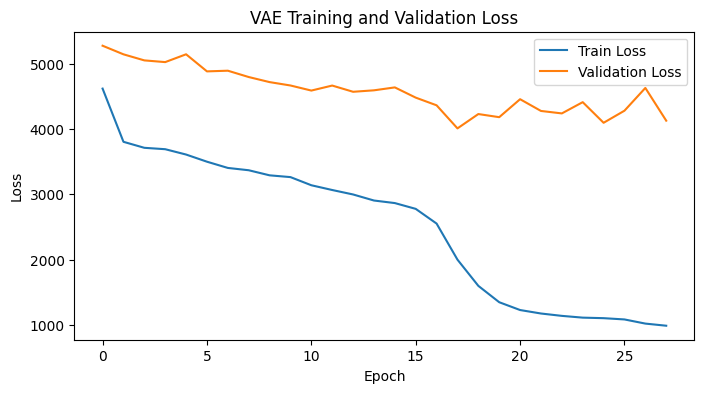

In [ ]:
if len(x_train_normal) > 0:
    print("\nTraining VAE on loaded A2D2 image data...")
    print(f"Training VAE on {len(x_train_normal)} images, validating on {len(x_val_normal)}.")

    batch_size = 16

    # Create training dataset with (input, target) pairs (input and target are the same)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train_normal, x_train_normal))
    train_ds = train_ds.shuffle(buffer_size=len(x_train_normal))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    # Create validation dataset with (input, target) pairs
    val_ds = tf.data.Dataset.from_tensor_slices((x_val_normal, x_val_normal))
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    for input_batch, target_batch in train_ds.take(1):
        print("Input batch shape:", input_batch.shape)
        print("Target batch shape:", target_batch.shape)

    # Define the Early Stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    )

    # Compile the VAE model
    vae = VAE(encoder, decoder, beta=1.1)
    vae.compile(optimizer=keras.optimizers.Adam())

    # Train the VAE
    history = vae.fit(
        train_ds,
        epochs=100,
        validation_data=val_ds,
        callbacks=[early_stopping_callback]
    )

    # Plot training and validation loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('VAE Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

else:
    print("Skipping VAE training as VAE model was not created or training data was not loaded.")

<h3>Section 4: Generating "Little Anomalies" and Select Test Data </h3>

In [ ]:
# Create a test set including normal samples and samples with anomalies.

desired_normal_test = 5
desired_anomalies = 5

# Use available validation data for normal test samples
num_normal_test = min(desired_normal_test, len(x_val_normal))
x_normal_test_subset = x_val_normal[:num_normal_test]
num_anomalies = min(desired_anomalies, len(x_val_normal) - num_normal_test)

if num_anomalies > 0:
    x_anomaly_source = x_val_normal[num_normal_test : num_normal_test + num_anomalies]

    # Simple Anomaly Generation: Add random noise to images
    def add_noise_as_anomaly(images, noise_factor=0.4):
        noisy_images = images + noise_factor * np.random.normal(
            loc=0.0, scale=1.0, size=images.shape
        )
        return np.clip(noisy_images, 0., 1.)

    x_anomalous_noisy = add_noise_as_anomaly(x_anomaly_source, noise_factor=0.4)

    print(f"\nCreated {num_anomalies} noisy anomalous samples.")
else:
    print("\nNot enough validation data to create anomalous samples (num_anomalies = 0).")
    if len(x_val_normal) > 0:
          img_shape = x_val_normal.shape[1:]
          x_anomalous_noisy = np.empty((0,) + img_shape, dtype=x_val_normal.dtype)
    else:
          x_anomalous_noisy = np.empty((0, 160, 256, 3), dtype=np.float32)


# Combine the normal and anomalous samples into a single test set
x_test_combined = np.concatenate((x_normal_test_subset, x_anomalous_noisy), axis=0)
is_anomalous_flags = [False] * num_normal_test + [True] * len(x_anomalous_noisy)

print(f"Combined test set size: {len(x_test_combined)}")


Created 5 noisy anomalous samples.
Combined test set size: 10


<h3>Section 5: Detect Anomalies using the Trained VAE</h3>

In [ ]:
if vae and len(x_test_combined) > 0:
    print("\nDetecting anomalies in the combined test set...")
    # Get VAE reconstructions for the combined test set
    x_test_reconstructed = vae.predict(x_test_combined)

    # Calculate reconstruction error
    def calculate_reconstruction_error(original, reconstructed):
         # Calculate MSE per sample
        return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))

    reconstruction_errors_combined = calculate_reconstruction_error(x_test_combined, x_test_reconstructed)
    # Separate errors for normal and anomalous data for plotting
    reconstruction_errors_normal_test = reconstruction_errors_combined[:num_normal_test]
    reconstruction_errors_anomalous_test = reconstruction_errors_combined[num_normal_test:]

else:
    print("Skipping anomaly detection.")
    reconstruction_errors_normal_test = []
    reconstruction_errors_anomalous_test = []



Detecting anomalies in the combined test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


<h3>Section 6: Visualize Results and Anomaly Thresholding </h3>

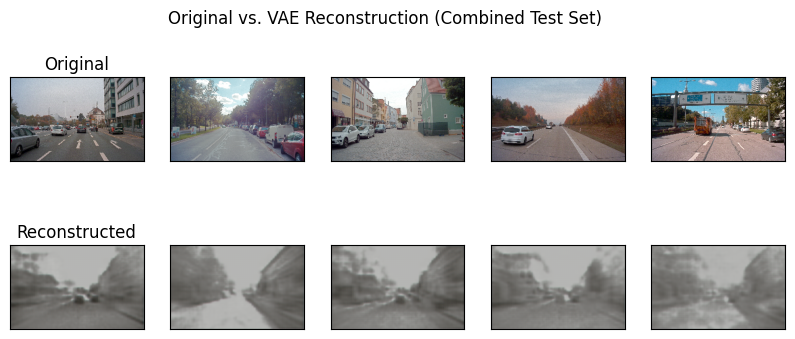

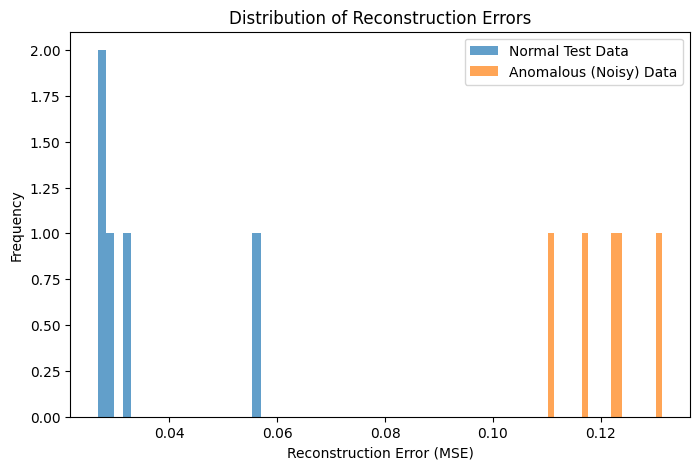


Calculated Anomaly Threshold (95th percentile of normal test errors): 0.0520
Anomalies correctly detected: 5/5
Normal samples incorrectly flagged as anomalous (False Positives): 1/5


In [ ]:
if len(x_test_combined) > 0:
    # Visualize some original and reconstructed images from the combined test set
    n_display = min(5, len(x_test_combined)) # Display up to 5 images
    plt.figure(figsize=(10, 4))
    for i in range(n_display):
        # Original image
        ax = plt.subplot(2, n_display, i + 1)
        plt.imshow(x_test_combined[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Original")

        # Reconstructed image
        ax = plt.subplot(2, n_display, i + 1 + n_display)
        plt.imshow(x_test_reconstructed[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Reconstructed")

    plt.suptitle("Original vs. VAE Reconstruction (Combined Test Set)")
    plt.show()


    # Plot distribution of reconstruction errors
    plt.figure(figsize=(8, 5))
    plt.hist(reconstruction_errors_normal_test, bins=20, alpha=0.7, label='Normal Test Data')
    if len(reconstruction_errors_anomalous_test) > 0:
        plt.hist(reconstruction_errors_anomalous_test, bins=20, alpha=0.7, label='Anomalous (Noisy) Data')
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Reconstruction Errors")
    plt.legend()
    plt.show()

    # Determine a simple threshold for anomaly detection
    # Use the error distribution of the normal test data subset
    if len(reconstruction_errors_normal_test) > 0:
        # Using percentile for thresholding can be more robust than mean+std for non-normal distributions
        threshold = np.percentile(reconstruction_errors_normal_test, 95) # 95th percentile of normal errors

        print(f"\nCalculated Anomaly Threshold (95th percentile of normal test errors): {threshold:.4f}")

        # Evaluate detection performance
        if len(reconstruction_errors_anomalous_test) > 0:
            correctly_identified_anomalies = np.sum(reconstruction_errors_anomalous_test > threshold)
            missed_anomalies = len(reconstruction_errors_anomalous_test) - correctly_identified_anomalies
            false_positives = np.sum(reconstruction_errors_normal_test > threshold)

            print(f"Anomalies correctly detected: {correctly_identified_anomalies}/{len(reconstruction_errors_anomalous_test)}")
            print(f"Normal samples incorrectly flagged as anomalous (False Positives): {false_positives}/{num_normal_test}")
        else:
             print("No anomalous data to evaluate detection against.")
    else:
        print("Not enough normal test data to calculate a meaningful threshold.")


else:
    print("Skipping visualization and evaluation as no test data was available.")
